<h1>Klasifikasi Tsunami dan Gempa - Machine Learning</h1>



In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine Learning, Klasifikasi, dan Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

<h1>Load Dataset<h1>

In [17]:
file_path = 'earthquake_data_tsunami.csv'
df_earthquakes_tsunami = pd.read_csv(file_path)
df_earthquakes_tsunami.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


<h1>Pembersihan Data</h1>

In [18]:
#Cek Kolom
print("Jumlah nilai kosong per kolom:\n", df_earthquakes_tsunami.isnull().sum())

#Validasi Ulang
print("\nSetelah imputasi, nilai kosong per kolom:\n", df_earthquakes_tsunami.isnull().sum())

Jumlah nilai kosong per kolom:
 magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

Setelah imputasi, nilai kosong per kolom:
 magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64


In [19]:
before = df_earthquakes_tsunami.shape
dupes = df_earthquakes_tsunami[df_earthquakes_tsunami.duplicated(keep=False)]
print(f"Jumlah baris duplikat (terhitung ganda): {dupes.shape[0]}")
df_earthquakes_tsunami2 = df_earthquakes_tsunami.drop_duplicates(keep='first')
print("Bentuk data sebelum/ setelah hapus duplikat:", before, "->", df_earthquakes_tsunami2.shape)

Jumlah baris duplikat (terhitung ganda): 0
Bentuk data sebelum/ setelah hapus duplikat: (782, 13) -> (782, 13)


<h3>Pemisahan Fitur-Target</h3>

In [20]:
y = df_earthquakes_tsunami['tsunami']
not_needed_columns = ['tsunami', 'Year', 'Month']
X = df_earthquakes_tsunami.drop(columns=not_needed_columns)

<h3>Train Test</h3>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state = 28, stratify=y)

print("Ukuran X_train, X_test:", X_train.shape, X_test.shape)

Ukuran X_train, X_test: (547, 10) (235, 10)


<h3>Random Forest</h3>

In [22]:
# ============================================================
#  PIPELINE: Scaling → Feature Selection → Random Forest
# ============================================================


# Rancang pipeline: gabungkan scaling, seleksi fitur, dan model Random Forest
pipe_rf = Pipeline(steps=[
    ('feat_select', SelectKBest()),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        random_state=28,
        n_estimators=-1
    ))
])

# GridSearch: dua jenis seleksi fitur (KBest dan Percentile) dengan kombinasi parameter model
params_grid_rf = [
    # Kandidat 1: pakai SelectKBest
    {
        'feat_select__k': np.arange(5, 15),        # jumlah fitur terbaik yang diuji
        'clf__n_estimators': [100, 300, 500],      # jumlah pohon
        'clf__max_depth': [None, 5, 10],           # batas kedalaman tiap pohon
        'clf__min_samples_split': [2, 5, 10]       # jumlah minimal sampel untuk split node
    },
    # Kandidat 2: pakai SelectPercentile
    {
        'feat_select': [SelectPercentile()],
        'feat_select__percentile': np.arange(30, 80, 10),
        'clf__n_estimators': [100, 300, 500],
        'clf__max_depth': [None, 5, 10],
        'clf__min_samples_split': [2, 5, 10]
    }
]

# StratifiedKFold: memastikan proporsi kelas tetap sama di setiap fold CV
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)

# Jalankan GridSearchCV: mencari kombinasi parameter terbaik dengan metrik F1
gscv_rf = GridSearchCV(
    pipe_rf,
    params_grid_rf,
    cv=SKF,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

print("Menjalankan GridSearch untuk Random Forest...")
start = time.time()

gscv_rf.fit(X_train, y_train)

print(f"GridSearch Random Forest selesai dalam {time.time() - start:.2f} detik")


Menjalankan GridSearch untuk Random Forest...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
GridSearch Random Forest selesai dalam 307.83 detik


<h3>Evaluasi Random Forest</h3>

CV Score (F1) terbaik: 0.8663305322128851
Kombinasi model terbaik: Pipeline(steps=[('feat_select', SelectKBest(k=np.int64(7))),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=10, n_estimators=300,
                                        random_state=28))])

Skor Test (akurasi) Random Forest: 0.8723404255319149

Fitur terbaik (terpilih): ['cdi' 'mmi' 'nst' 'dmin' 'gap' 'latitude' 'longitude']


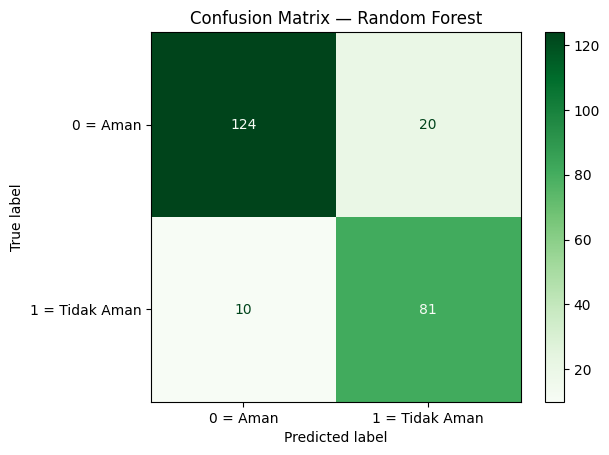


Classification Report — Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       144
           1       0.80      0.89      0.84        91

    accuracy                           0.87       235
   macro avg       0.86      0.88      0.87       235
weighted avg       0.88      0.87      0.87       235

Accuracy: 0.8723
Precision: 0.8020
Recall: 0.8901
F1-Score: 0.8438


In [23]:
#  Evaluasi hasil GridSearch
print("CV Score (F1) terbaik:", gscv_rf.best_score_)
print("Kombinasi model terbaik:", gscv_rf.best_estimator_)

rf_test_score = gscv_rf.best_estimator_.score(X_test, y_test)
print("\nSkor Test (akurasi) Random Forest:", rf_test_score)

#  Fitur terbaik (jika selector mendukung get_support)
selector = gscv_rf.best_estimator_.named_steps['feat_select']
if hasattr(selector, 'get_support'):
    mask = selector.get_support()
    selected = np.array(X.columns)[mask]
    print("\nFitur terbaik (terpilih):", selected)

#  Confusion Matrix & Classification Report
rf_pred = gscv_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['0 = Aman','1 = Tidak Aman'])
disp_rf.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix — Random Forest")
plt.show()

# Silakan diisi bagian ini dengan kode yang tepat ()
print("\nClassification Report — Random Forest:\n", classification_report(y_test, rf_pred))
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred):.4f}")
print(f"Recall: {recall_score(y_test, rf_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_pred):.4f}")


<h3>Logistic Regression</h3>

In [24]:
# ============================================================
#  PIPELINE: Scaling → Feature Selection → Logistic Regression
# ============================================================

pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),  # placeholder, nanti diganti lewat GridSearch
    ('feat_select', SelectKBest()),
    ('clf', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        max_iter=500
    ))
])

# GridSearch: tambahkan pilihan dua scaler (Standard & MinMax)
params_grid_lr = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()],     # <--- Tambahan penting
        'feat_select': [SelectKBest()],
        'feat_select__k': np.arange(2, 10),
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10],
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],     # <--- Tambahan penting juga
        'feat_select': [SelectPercentile()],
        'feat_select__percentile': np.arange(20, 80, 10),
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10],
    }
]

# Stratified K-Fold Cross Validation
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)

# Jalankan GridSearchCV untuk mencari kombinasi terbaik
gscv_lr = GridSearchCV(
    pipe_lr,
    params_grid_lr,
    cv=SKF,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

print("Menjalankan GridSearch untuk Logistic Regression...")
start = time.time()
gscv_lr.fit(X_train, y_train)
print(f"GridSearch Logistic Regression selesai dalam {time.time() - start:.2f} detik")

Menjalankan GridSearch untuk Logistic Regression...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
GridSearch Logistic Regression selesai dalam 1.87 detik


<h3>Evaluasi Logistic Regression</h3>

CV Score (F1) terbaik: 0.7963007289739963
Kombinasi model terbaik: Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_select', SelectKBest(k=np.int64(4))),
                ('clf',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=500, solver='liblinear'))])

Skor Test (akurasi) Logistic Regression: 0.8382978723404255

Fitur terbaik (terpilih): ['cdi' 'nst' 'dmin' 'longitude']


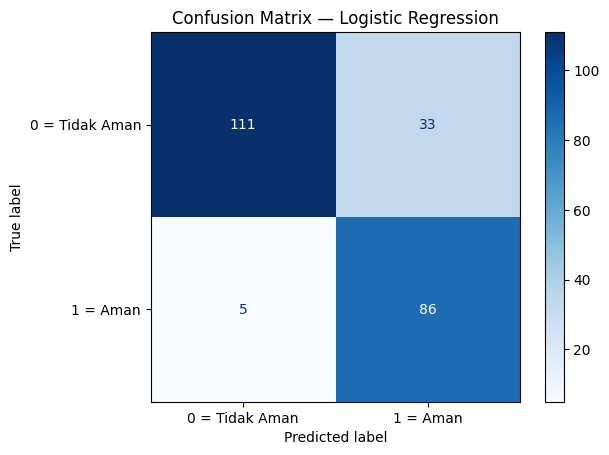


Classification Report — Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      0.77      0.85       144
           1       0.72      0.95      0.82        91

    accuracy                           0.84       235
   macro avg       0.84      0.86      0.84       235
weighted avg       0.87      0.84      0.84       235

Accuracy: 0.8383
Precision: 0.7227
Recall: 0.9451
F1-Score: 0.8190


In [25]:
# Evaluasi hasil terbaik
print("CV Score (F1) terbaik:", gscv_lr.best_score_)
print("Kombinasi model terbaik:", gscv_lr.best_estimator_)

lr_test_score = gscv_lr.best_estimator_.score(X_test, y_test)
print("\nSkor Test (akurasi) Logistic Regression:", lr_test_score)

# Fitur terbaik (jika feature selector mendukung get_support)
selector = gscv_lr.best_estimator_.named_steps['feat_select']
if hasattr(selector, 'get_support'):
    mask = selector.get_support()
    selected = np.array(X.columns)[mask]
    print("\nFitur terbaik (terpilih):", selected)

# Confusion Matrix & Classification Report
lr_pred = gscv_lr.predict(X_test)
cm_lr = confusion_matrix(y_test, lr_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['0 = Tidak Aman','1 = Aman'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

print("\nClassification Report — Logistic Regression:\n", classification_report(y_test, lr_pred))
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"Recall: {recall_score(y_test, lr_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_pred):.4f}")

<h3>Perbandingan Random Forest dan Logistic Regression</h3>

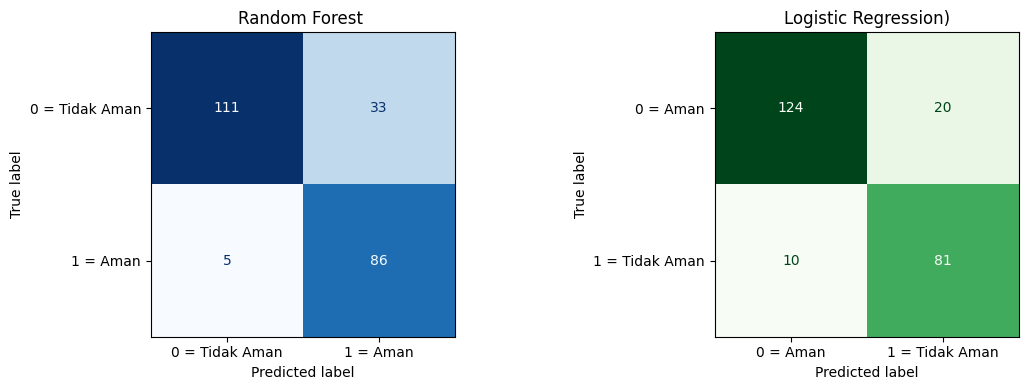

PERBANDINGAN METRIK EVALUASI

              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.872340   0.801980 0.890110  0.843750
Logistic Regression  0.838298   0.722689 0.945055  0.819048

Model terbaik berdasarkan F1-Score adalah: Random Forest


In [26]:
# Buat figure dengan 2 subplot berdampingan (1 baris, 2 kolom)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot Confusion Matrix untuk Random Forest
disp_lr.plot(ax=ax1, cmap=plt.cm.Blues, colorbar=False)
ax1.set_title("Random Forest ")

# Plot Confusion Matrix untuk Logistic Regression
disp_rf.plot(ax=ax2, cmap=plt.cm.Greens, colorbar=False)
ax2.set_title("Logistic Regression)")

# Rapikan tata letak agar subplot tidak tumpang tindih
plt.tight_layout()
plt.show()

# Hitung metrik untuk kedua model
metrics_comparison = {
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, lr_pred)
    ],
    'Precision': [
        precision_score(y_test, rf_pred),
        precision_score(y_test, lr_pred)
    ],
    'Recall': [
        recall_score(y_test, rf_pred),
        recall_score(y_test, lr_pred)
    ],
    'F1-Score': [
        f1_score(y_test, rf_pred),
        f1_score(y_test, lr_pred)
    ]
}

# Buat DataFrame untuk perbandingan
df_comparison = pd.DataFrame(metrics_comparison)

print("PERBANDINGAN METRIK EVALUASI\n")
print(df_comparison.to_string(index=False))

# Model terbaik berdasarkan F1-Score
best_idx_f1 = df_comparison['F1-Score'].idxmax()
best_model = df_comparison.loc[best_idx_f1, 'Model']
print(f"\nModel terbaik berdasarkan F1-Score adalah: {best_model}")